In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentimentanalyser.utils.data  import Path, pad_collate, grandparent_splitter
from sentimentanalyser.utils.data  import parent_labeler, listify
from sentimentanalyser.data.text   import TextList, ItemList, SplitData
from sentimentanalyser.utils.files import pickle_dump, pickle_load

from sentimentanalyser.preprocessing.processor import TokenizerProcessor, NuemericalizeProcessor
from sentimentanalyser.preprocessing.processor import CategoryProcessor

In [3]:
from functools import partial

In [4]:
path_imdb = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/imdb")

In [5]:
proc_tok = TokenizerProcessor()
proc_num = NuemericalizeProcessor()
proc_cat = CategoryProcessor()

In [6]:
tl_imdb = TextList.from_files(path=path_imdb, folders=['train','test'])
sd_imdb = tl_imdb.split_by_func(partial(grandparent_splitter, valid_name='test'))
ll_imdb = sd_imdb.label_by_func(parent_labeler, proc_x=[proc_tok, proc_num], proc_y=proc_cat)

In [7]:
imdb_data = ll_imdb.clas_databunchify(64)

In [8]:
x1,y1 = next(iter(imdb_data.train_dl))

In [9]:
import torch
import torchtext
import torch.nn.functional as F
from torch import nn
from torchtext import vocab
from sentimentanalyser.utils.preprocessing import default_spec_tok

In [10]:
path_cache = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Models/WordEmbeddings')

In [11]:
ft_eng = vocab.FastText(cache=path_cache)

In [43]:
local_vocab = proc_num.vocab

In [1]:
from sentimentanalyser.utils.callbacks import sched_cos, combine_scheds
from sentimentanalyser.callbacks.training import LR_Find, CudaCallback, GradientClipping
from sentimentanalyser.callbacks.training import LR_FindCustom
from sentimentanalyser.callbacks.progress import ProgressCallback
from sentimentanalyser.callbacks.scheduler import ParamScheduler
from sentimentanalyser.callbacks.stats import AvgStatsCallback
from sentimentanalyser.callbacks.recorder import Recorder
from sentimentanalyser.training.trainer import Trainer

In [13]:
from sentimentanalyser.utils.dev import get_info, print_dims
from sentimentanalyser.utils.training import get_embedding_vectors
from sentimentanalyser.utils.metrics import accuracy
from tqdm.auto import tqdm

## Models

### AWD Model

In [132]:
class WeightDropout(nn.Module):
    def __init__(self, module, dropout=0.5):
        super().__init__()
        self.module, self.dropout = module, dropout
        
        self.layer_names = self.get_layer_names()
        for layer_name in self.layer_names:
            weight = getattr(self.module, layer_name)
            self.register_parameter(layer_name+'_raw', nn.Parameter(weight.data))
        return
    
    def _setweights(self):
        for layer_name in self.layer_names:
            raw_w = getattr(self, layer_name+'_raw')
            self.module._parameters[layer_name] = F.dropout(raw_w, self.dropout,
                                                            training=self.training)
        return
    
    def get_layer_names(self):
        names = [f"weight_hh_l{i}" for i in range(self.module.num_layers)]
        if self.module.bidirectional:
            names = names + [name+'_reverse' for name in names]
        return names
    
    def forward(self, *args):
        self._setweights()
        self.module.flatten_parameters()
        return self.module.forward(*args)

In [154]:
class AWDModel(nn.Module):
    def __init__(self, local_vocab, torchtext_vocab,
                 hidden_sz=256, output_sz=2, dropout=0.5,
                 pad_idx=1, num_layers=2, bidirectional=True):
        super().__init__()
        
        self.pad_idx = pad_idx
        
        self.bidir = 2 if bidirectional else 1
        
        embd_vecs = get_embedding_vectors(local_vocab, torchtext_vocab)
        
        self.embeddings = nn.Embedding.from_pretrained(embd_vecs,
                                                       freeze=False,
                                                       padding_idx=pad_idx)
        
        self.dropout = nn.Dropout(dropout)
        
        self. rnn    = WeightDropout(nn.LSTM(embd_vecs.shape[1],
                                             hidden_sz,
                                             batch_first=True,
                                             dropout=dropout,
                                             num_layers=num_layers,
                                             bidirectional=bidirectional))
        
        self.linear  = nn.Linear((2+num_layers)*self.bidir*hidden_sz, output_sz)
        return
    
    def forward(self, xb):
        seq_lens, mask = get_info(xb, self.pad_idx)
        
        embedded = self.dropout(self.embeddings(xb))
        
        packed = nn.utils.rnn.pack_padded_sequence(embedded, seq_lens,
                                                   batch_first=True)
        
        packed_out, (hidden_st, cell_st) = self.rnn(packed)
        
        lstm_out, lens = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        
        avg_pool = F.adaptive_avg_pool1d(lstm_out.transpose(1,2), 1).squeeze()
        max_pool = F.adaptive_max_pool1d(lstm_out.transpose(1,2), 1).squeeze()
        
        hidden_st = hidden_st.view(hidden_st.shape[1], -1)
        
        combined = torch.cat([max_pool, avg_pool, hidden_st], dim=1)
        return self.linear(combined)

### Attention AWD Model

In [155]:
class WordSentenceAttention(nn.Module):
    def __init__(self, hidden_sz):
        super().__init__()
        
        self.context_weight     = nn.Parameter(torch.Tensor(hidden_sz).uniform_(-0.1,0.1))
        self.context_projection = nn.Linear(hidden_sz, hidden_sz)
        return
    
    def forward(self, context):
        context_proj = torch.tanh(self.context_projection(context))
        αt = context_proj.matmul(self.context_weight)
        attn_score = F.softmax(αt, dim=1).unsqueeze(2)
        sentence = context.transpose(1,2).bmm(attn_score)
        return sentence.squeeze(2)

In [160]:
class AttnAWDModel(nn.Module):
    def __init__(self,local_vocab, torch_text_vocab,
                 hidden_sz=256, output_sz=2, dropout=0.5,
                 pad_idx=1, num_layers=2, bidirectional=True):
        super().__init__()
        
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        bidir = 2 if bidirectional else 1
        embd_vecs = get_embedding_vectors(local_vocab, torch_text_vocab)
        
        self.embedding = nn.Embedding.from_pretrained(embd_vecs,
                                                      freeze=False,
                                                      padding_idx=pad_idx)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.rnn      = WeightDropout(nn.LSTM(embd_vecs.shape[1],
                                              hidden_sz,
                                              batch_first=True,
                                              dropout=dropout,
                                              num_layers=num_layers,
                                              bidirectional=bidirectional))
        
        self.WSattn   = WordSentenceAttention(bidir*hidden_sz)
        self.linear   = nn.Linear(bidir*hidden_sz, output_sz)
        return
    
    def forward(self, xb):
        seq_lens, mask = get_info(xb, self.pad_idx)
        
        embedded = self.dropout(self.embedding(xb))
        packed_i = nn.utils.rnn.pack_padded_sequence(embedded,seq_lens,
                                                     batch_first=True)

        packed_o, (hidden_st, cell_st) = self.rnn(packed_i)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_o, batch_first=True)
        
        sentence = self.WSattn(outputs)
        return self.linear(sentence)

## Testing

In [161]:
model = AttnAWDModel(local_vocab, ft_eng)

In [162]:
y = model(x1)

In [163]:
y.shape

torch.Size([64, 2])

## Training

In [145]:
def get_params(model):
    emb, wgts, biases = [],[],[]
    for name, param in model.named_parameters():
        if ('embedding' in name.split('.')):
            emb.append(param)
        elif ('weight' in name.split('.')):
            wgts.append(param)
        elif ('bias' in name.split('.')):
            biases.append(param)
    return emb, wgts, biases

In [146]:
def pg_dicts(pgs):
    return [{'params': p} for p in pgs]

In [147]:
def get_basic(Model, local_vocab, torchtext_vocab, num_layers=1, disc_train=False):
    model = Model(local_vocab, torchtext_vocab, num_layers=num_layers)
    loss_func = nn.CrossEntropyLoss()
    if disc_train:
        pgs = pg_dicts(get_params(model))
        opt = torch.optim.Adam(pgs, lr=1e-3)
    else:
        opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
    return model, loss_func, opt

In [148]:
finder = Trainer(imdb_data,*get_basic(AWDModel,local_vocab,ft_eng,
                                      num_layers=2),
                 cb_funcs=[LR_Find,Recorder,CudaCallback])

In [149]:
finder.fit()

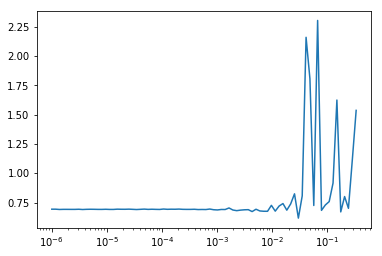

In [150]:
finder.recorder.plot(skip_last=2)

In [151]:
sched = combine_scheds([0.3, 0.7], [sched_cos(1e-4, 1e-3), sched_cos(1e-3, 3e-5)])

In [168]:
trainer_awd = Trainer(imdb_data, *get_basic(AWDModel, local_vocab, ft_eng,
                                        num_layers=2),
                  cb_funcs=[
                      partial(AvgStatsCallback, [accuracy]),
                      partial(ParamScheduler,'lr', [sched]),
                      partial(GradientClipping, clip=0.1),
                      ProgressCallback,
                      CudaCallback,
                      Recorder
                  ])

In [169]:
trainer_atawd = Trainer(imdb_data, *get_basic(AWDModel, local_vocab, ft_eng,
                                        num_layers=2),
                  cb_funcs=[
                      partial(AvgStatsCallback, [accuracy]),
                      partial(ParamScheduler,'lr', [sched]),
                      partial(GradientClipping, clip=0.1),
                      ProgressCallback,
                      CudaCallback,
                      Recorder
                  ])

In [170]:
trainer_awd.fit()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.471524,0.746120,0.327442,0.857320,01:33
1,0.247158,0.901160,0.226350,0.910040,01:34
2,0.146061,0.945920,0.233303,0.913200,01:33


In [171]:
trainer_atawd.fit()

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.479039,0.751760,0.269981,0.889760,01:33
1,0.245348,0.901520,0.251619,0.900720,01:33
2,0.145072,0.948440,0.235392,0.913640,01:33


In [ ]:
hoo